In [3]:
import pickle as pk
import tensorflow as tf
import numpy as np
import tensorflow as tf
from tensorflow.keras import regularizers

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

import os, sys, pathlib, h5py, time

from models import make_model

import pickle as pk

from astropy.nddata import block_reduce

from matplotlib import pyplot as plt

from astropy.io import fits

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2023-01-04 14:08:45.370253: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 24753 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0004:04:00.0, compute capability: 7.0
2023-01-04 14:08:45.372549: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31016 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0004:05:00.0, compute capability: 7.0
2023-01-04 14:08:45.374830: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 31016 MB memory:  -> device: 2, name: Tesla V100-SXM2-32GB, pci bus id: 0035:03:00.0, compute capability: 7.0
2023-01-04 14:08:45.377111: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 31016 MB memory:  -> device: 3, name: Tesla V100-SXM2-32GB, pci bus id

# Load and perform some cuts on data

In [4]:
data_dir = '/project/r/rbond/jorlo/datasets/act_freq_stamps/'

with np.load(data_dir + 'all_clusters.npz') as data:
    stamps = data['arr_0']


In [5]:
stamps.shape

(4195, 41, 41, 3)

In [6]:
#cuts out any maps that have nans in them
flags = []
for i in range(stamps.shape[0]):
        if np.any(np.isnan(stamps[i,...])):
                flags.append(i)

stamps = np.delete(stamps, flags, axis = 0)

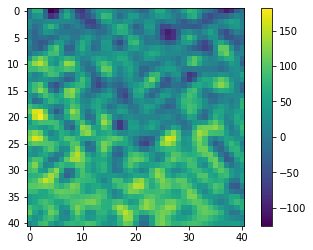

In [7]:
plt.imshow(stamps[50,...,0])
plt.colorbar()

In [8]:
stamps /= 300

In [9]:
tot = stamps.shape[0]
train_size = int(0.7 * tot)
val_size = int(0.15 * tot)
test_size = int(0.15 * tot)

train_stamps = stamps[:train_size]
val_stamps = stamps[train_size:train_size + val_size]
test_stamps = stamps[train_size + val_size:]

input_shape = train_stamps.shape[1:]

act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')

labels = act_catalog[1].data['M500Cal']

train_labels = labels[:train_size]
val_labels = labels[train_size:train_size + val_size]
test_labels = labels[train_size + val_size:]

#This just sets the # of samples we include in a trianing epoch, which is called the batch size. Autotune is a bit
#of magic that allows tf to dynamically set some hyperparameters in an optimal way. See https://www.tensorflow.org/guide/data_performance
batch_size = 500
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((train_stamps, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_stamps, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_stamps, test_labels))

#We shuffle our data (i.e. just mix up the order) and batch it
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch_size)

#Preloads data into memory
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

2023-01-04 14:08:50.368590: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 24753 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0004:04:00.0, compute capability: 7.0
2023-01-04 14:08:50.370888: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31016 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0004:05:00.0, compute capability: 7.0
2023-01-04 14:08:50.373155: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 31016 MB memory:  -> device: 2, name: Tesla V100-SXM2-32GB, pci bus id: 0035:03:00.0, compute capability: 7.0
2023-01-04 14:08:50.375420: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 31016 MB memory:  -> device: 3, name: Tesla V100-SXM2-32GB, pci bus id

# CNN Model

In [56]:
#Very simple model, this is just from the TF tutorial

from tensorflow.keras import layers

model = tf.keras.models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

In [57]:
toc = time.time()
#Actually fits the model to the data. data_augmentation.flow generates augmented data sets from the data sets we pass it.
#Epochs sets the number of rounds of fitting to perform. 
history = model.fit(train_dataset, epochs=int(50), 
                    validation_data=val_dataset)
tic = time.time()

print('Distributed time: ', tic-toc)

#Evaluate how well our model does
test_loss = model.evaluate(test_dataset, verbose=2)

Epoch 1/50


2022-12-02 17:14:48.153909: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-12-02 17:15:06.995527: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-02 17:15:06.996197: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-02 17:15:06.996230: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-02 17:15:06.996813: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-02 17:15:06.996877: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


6/6 [==============================] - 35s 115ms/step - loss: 1.8759 - val_loss: 1.3473
Epoch 2/50
6/6 [==============================] - 0s 30ms/step - loss: 1.1238 - val_loss: 0.9743
Epoch 3/50
6/6 [==============================] - 0s 29ms/step - loss: 1.0241 - val_loss: 1.0253
Epoch 4/50
6/6 [==============================] - 0s 28ms/step - loss: 0.9366 - val_loss: 1.0009
Epoch 5/50
6/6 [==============================] - 0s 29ms/step - loss: 0.9197 - val_loss: 0.9164
Epoch 6/50
6/6 [==============================] - 0s 27ms/step - loss: 0.8630 - val_loss: 0.9224
Epoch 7/50
6/6 [==============================] - 0s 28ms/step - loss: 0.8142 - val_loss: 0.9000
Epoch 8/50
6/6 [==============================] - 0s 28ms/step - loss: 0.7948 - val_loss: 0.8958
Epoch 9/50
6/6 [==============================] - 0s 29ms/step - loss: 0.7981 - val_loss: 0.9261
Epoch 10/50
6/6 [==============================] - 0s 28ms/step - loss: 0.8317 - val_loss: 0.8892
Epoch 11/50
6/6 [=====================

In [32]:
from tensorflow.keras import optimizers, layers, models, regularizers

model = tf.keras.models.Sequential([
layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer= regularizers.l2(0.001), input_shape=input_shape),
layers.MaxPooling2D(),
layers.Dropout(0.2),
layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer = regularizers.l2(0.001)),
layers.MaxPooling2D(),
layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer = regularizers.l2(0.001)),
layers.MaxPooling2D(),
layers.Dropout(0.2),
layers.Flatten(),
layers.Dense(512, activation='relu', kernel_regularizer = regularizers.l2(0.001)),
layers.Dense(2)])

model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))



In [35]:
toc = time.time()
#Actually fits the model to the data. data_augmentation.flow generates augmented data sets from the data sets we pass it.
#Epochs sets the number of rounds of fitting to perform. 

data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=360, width_shift_range=4,
    height_shift_range=4,zoom_range=0.3)


history = model.fit(data_augmentation.flow(train_stamps, train_labels), epochs=int(50), 
                    validation_data=val_dataset)
tic = time.time()

print('Distributed time: ', tic-toc)

#Evaluate how well our model does
test_loss = model.evaluate(test_dataset, verbose=2)

Epoch 1/50
92/92 [==============================] - 3s 23ms/step - loss: 0.9632 - val_loss: 0.9910
Epoch 2/50
92/92 [==============================] - 2s 24ms/step - loss: 0.8939 - val_loss: 0.9876
Epoch 3/50
92/92 [==============================] - 2s 24ms/step - loss: 0.8773 - val_loss: 0.9375
Epoch 4/50
92/92 [==============================] - 2s 23ms/step - loss: 0.8628 - val_loss: 1.0255
Epoch 5/50
92/92 [==============================] - 2s 23ms/step - loss: 0.8110 - val_loss: 0.9692
Epoch 6/50
92/92 [==============================] - 2s 23ms/step - loss: 0.8129 - val_loss: 0.9733
Epoch 7/50
92/92 [==============================] - 2s 23ms/step - loss: 0.7913 - val_loss: 0.9357
Epoch 8/50
92/92 [==============================] - 2s 24ms/step - loss: 0.7803 - val_loss: 0.8934
Epoch 9/50
92/92 [==============================] - 2s 24ms/step - loss: 0.7693 - val_loss: 0.8994
Epoch 10/50
92/92 [==============================] - 2s 23ms/step - loss: 0.7721 - val_loss: 0.8937
Epoch 11/

## Ntampka Freqs

In [10]:
from tensorflow.keras import layers

model = tf.keras.models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2), strides = 2))
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.0005))

In [14]:
#data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=360, width_shift_range=4,
#    height_shift_range=4,zoom_range=0.3)


history = model.fit(train_dataset, epochs=int(50), 
                    validation_data=val_dataset)

Epoch 1/50
6/6 [==============================] - 7s 60ms/step - loss: 5.9197 - val_loss: 3.2983
Epoch 2/50
6/6 [==============================] - 0s 24ms/step - loss: 3.4832 - val_loss: 2.2958
Epoch 3/50
6/6 [==============================] - 0s 25ms/step - loss: 2.5855 - val_loss: 2.2507
Epoch 4/50
6/6 [==============================] - 0s 24ms/step - loss: 2.3220 - val_loss: 2.0964
Epoch 5/50
6/6 [==============================] - 0s 25ms/step - loss: 1.8588 - val_loss: 1.7375
Epoch 6/50
6/6 [==============================] - 0s 25ms/step - loss: 1.9862 - val_loss: 1.6757
Epoch 7/50
6/6 [==============================] - 0s 24ms/step - loss: 1.6580 - val_loss: 1.5635
Epoch 8/50
6/6 [==============================] - 0s 23ms/step - loss: 1.6516 - val_loss: 1.4456
Epoch 9/50
6/6 [==============================] - 0s 23ms/step - loss: 1.4124 - val_loss: 1.2994
Epoch 10/50
6/6 [==============================] - 0s 23ms/step - loss: 1.4118 - val_loss: 1.2241
Epoch 11/50
6/6 [============

In [15]:
errs_test = []
for thing in test_dataset:
    for i in range(thing[1].shape[0]):
        truth = thing[1][i]
        pred = model.predict(np.expand_dims(thing[0][i], axis = 0))
        errs_test.append((truth.numpy()-pred)/pred)
        
errs_val = []
for thing in val_dataset:
    for i in range(thing[1].shape[0]):
        truth = thing[1][i]
        pred = model.predict(np.expand_dims(thing[0][i], axis = 0))
        errs_val.append((truth.numpy()-pred)/pred)

In [16]:
print(np.mean(np.abs(errs_test)))
print(np.mean(np.abs(errs_val)))

0.1430503
0.14009583


# Compton y

In [17]:
data_dir = '/project/r/rbond/jorlo/datasets/act_y_stamps/'

with np.load(data_dir + 'all_clusters.npz') as data:
    stamps = data['arr_0']

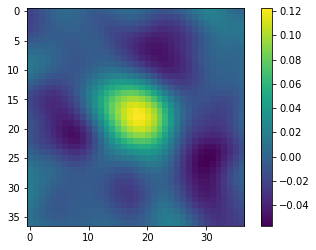

In [18]:
plt.imshow(stamps[50])
plt.colorbar()

In [19]:
#cuts out any maps that have nans in them
flags = []
for i in range(stamps.shape[0]):
        if np.any(np.isnan(stamps[i,...])):
                flags.append(i)

stamps = np.delete(stamps, flags, axis = 0)

In [20]:
factor = 2

stamps *= factor

In [21]:
tot = stamps.shape[0]
train_size = int(0.7 * tot)
val_size = int(0.15 * tot)
test_size = int(0.15 * tot)

train_stamps = stamps[:train_size]
val_stamps = stamps[train_size:train_size + val_size]
test_stamps = stamps[train_size + val_size:]

input_shape = train_stamps.shape[1:]

act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')

labels = act_catalog[1].data['M500Cal'][:tot]

train_labels = labels[:train_size]
val_labels = labels[train_size:train_size + val_size]
test_labels = labels[train_size + val_size:]

#This just sets the # of samples we include in a trianing epoch, which is called the batch size. Autotune is a bit
#of magic that allows tf to dynamically set some hyperparameters in an optimal way. See https://www.tensorflow.org/guide/data_performance
batch_size = 500
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((train_stamps, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_stamps, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_stamps, test_labels))

#We shuffle our data (i.e. just mix up the order) and batch it
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch_size)

#Preloads data into memory
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [22]:
model = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=input_shape),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(1)
  ])

model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

In [23]:
toc = time.time()
#Actually fits the model to the data. data_augmentation.flow generates augmented data sets from the data sets we pass it.
#Epochs sets the number of rounds of fitting to perform. 
history = model.fit(train_dataset, epochs=int(50), 
                    validation_data=val_dataset)
tic = time.time()

print('Distributed time: ', tic-toc)

#Evaluate how well our model does
test_loss = model.evaluate(test_dataset, verbose=2)


Epoch 1/50
6/6 [==============================] - 1s 36ms/step - loss: 3.3862 - val_loss: 2.8140
Epoch 2/50
6/6 [==============================] - 0s 19ms/step - loss: 2.4829 - val_loss: 1.7023
Epoch 3/50
6/6 [==============================] - 0s 17ms/step - loss: 1.2793 - val_loss: 0.6766
Epoch 4/50
6/6 [==============================] - 0s 16ms/step - loss: 0.7680 - val_loss: 0.9709
Epoch 5/50
6/6 [==============================] - 0s 18ms/step - loss: 0.8797 - val_loss: 0.7144
Epoch 6/50
6/6 [==============================] - 0s 18ms/step - loss: 0.6484 - val_loss: 0.5803
Epoch 7/50
6/6 [==============================] - 0s 18ms/step - loss: 0.6187 - val_loss: 0.5449
Epoch 8/50
6/6 [==============================] - 0s 18ms/step - loss: 0.5356 - val_loss: 0.5019
Epoch 9/50
6/6 [==============================] - 0s 18ms/step - loss: 0.5210 - val_loss: 0.4608
Epoch 10/50
6/6 [==============================] - 0s 19ms/step - loss: 0.4786 - val_loss: 0.4512
Epoch 11/50
6/6 [============

In [24]:
predictions = model.predict(train_dataset)

errs = []
for i in range(len(train_labels)):
    errs.append((train_labels[i]-predictions[i])/predictions[i])

In [25]:
np.mean(np.abs(errs))

0.37209642

# Compton-y CNN

In [26]:
data_dir = '/project/r/rbond/jorlo/datasets/act_y_stamps/'

with np.load(data_dir + 'all_clusters.npz') as data:
    stamps = data['arr_0']

In [27]:
#cuts out any maps that have nans in them
flags = []
for i in range(stamps.shape[0]):
        if np.any(np.isnan(stamps[i,...])):
                flags.append(i)

stamps = np.delete(stamps, flags, axis = 0)

In [28]:
factor = 2
stamps *=factor

In [29]:
stamps = np.expand_dims(stamps, axis=-1)


In [30]:
tot = stamps.shape[0]
train_size = int(0.7 * tot)
val_size = int(0.15 * tot)
test_size = int(0.15 * tot)

train_stamps = stamps[:train_size]
val_stamps = stamps[train_size:train_size + val_size]
test_stamps = stamps[train_size + val_size:]

input_shape = train_stamps.shape[1:]

act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')

labels = act_catalog[1].data['M500Cal'][:tot]

train_labels = labels[:train_size]
val_labels = labels[train_size:train_size + val_size]
test_labels = labels[train_size + val_size:]

#This just sets the # of samples we include in a trianing epoch, which is called the batch size. Autotune is a bit
#of magic that allows tf to dynamically set some hyperparameters in an optimal way. See https://www.tensorflow.org/guide/data_performance
batch_size = 100
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((train_stamps, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_stamps, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_stamps, test_labels))

#We shuffle our data (i.e. just mix up the order) and batch it
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch_size)

#Preloads data into memory
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [31]:
#Very simple model, this is just from the TF tutorial

from tensorflow.keras import layers

model = tf.keras.models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

In [32]:
toc = time.time()
#Actually fits the model to the data. data_augmentation.flow generates augmented data sets from the data sets we pass it.
#Epochs sets the number of rounds of fitting to perform. 
history = model.fit(train_dataset, epochs=int(50), 
                    validation_data=val_dataset)
tic = time.time()

print('Distributed time: ', tic-toc)

#Evaluate how well our model does
test_loss = model.evaluate(test_dataset, verbose=2)

Epoch 1/50
30/30 [==============================] - 2s 16ms/step - loss: 3.1265 - val_loss: 0.2178
Epoch 2/50
30/30 [==============================] - 0s 7ms/step - loss: 0.1756 - val_loss: 0.1944
Epoch 3/50
30/30 [==============================] - 0s 7ms/step - loss: 0.1299 - val_loss: 0.1894
Epoch 4/50
30/30 [==============================] - 0s 7ms/step - loss: 0.1232 - val_loss: 0.1642
Epoch 5/50
30/30 [==============================] - 0s 7ms/step - loss: 0.1164 - val_loss: 0.1562
Epoch 6/50
30/30 [==============================] - 0s 7ms/step - loss: 0.1055 - val_loss: 0.2324
Epoch 7/50
30/30 [==============================] - 0s 7ms/step - loss: 0.1176 - val_loss: 0.2151
Epoch 8/50
30/30 [==============================] - 0s 7ms/step - loss: 0.1200 - val_loss: 0.1443
Epoch 9/50
30/30 [==============================] - 0s 7ms/step - loss: 0.1064 - val_loss: 0.1363
Epoch 10/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0870 - val_loss: 0.1370
Epoch 11/50
30/30 

In [33]:
comp = test_dataset

predictions = model.predict(comp)



errs = []
for i in range(len(comp)):
    errs.append((comp[i]-predictions[i])/predictions[i])

TypeError: 'PrefetchDataset' object is not subscriptable

In [34]:
np.mean(np.abs(errs))

/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

## Ntampaka

In [35]:
from tensorflow.keras import layers

model = tf.keras.models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2), strides = 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.0005))

In [36]:
toc = time.time()
#Actually fits the model to the data. data_augmentation.flow generates augmented data sets from the data sets we pass it.
#Epochs sets the number of rounds of fitting to perform. 
history = model.fit(train_dataset, epochs=int(50), 
                    validation_data=val_dataset)
tic = time.time()

print('Distributed time: ', tic-toc)

#Evaluate how well our model does
test_loss = model.evaluate(test_dataset, verbose=2)

Epoch 1/50
30/30 [==============================] - 1s 12ms/step - loss: 5.3527 - val_loss: 0.8549
Epoch 2/50
30/30 [==============================] - 0s 6ms/step - loss: 0.2531 - val_loss: 0.2402
Epoch 3/50
30/30 [==============================] - 0s 6ms/step - loss: 0.1474 - val_loss: 0.1872
Epoch 4/50
30/30 [==============================] - 0s 6ms/step - loss: 0.1337 - val_loss: 0.1839
Epoch 5/50
30/30 [==============================] - 0s 6ms/step - loss: 0.1252 - val_loss: 0.1767
Epoch 6/50
30/30 [==============================] - 0s 7ms/step - loss: 0.1224 - val_loss: 0.1716
Epoch 7/50
30/30 [==============================] - 0s 6ms/step - loss: 0.1191 - val_loss: 0.1663
Epoch 8/50
30/30 [==============================] - 0s 6ms/step - loss: 0.1142 - val_loss: 0.1788
Epoch 9/50
30/30 [==============================] - 0s 6ms/step - loss: 0.1194 - val_loss: 0.1586
Epoch 10/50
30/30 [==============================] - 0s 7ms/step - loss: 0.1041 - val_loss: 0.1645
Epoch 11/50
30/30 

In [37]:
errs_test = []
for thing in test_dataset:
    for i in range(thing[1].shape[0]):
        truth = thing[1][i]
        pred = model.predict(np.expand_dims(thing[0][i], axis = 0))
        errs_test.append((truth.numpy()-pred)/pred)
        
errs_val = []
for thing in val_dataset:
    for i in range(thing[1].shape[0]):
        truth = thing[1][i]
        pred = model.predict(np.expand_dims(thing[0][i], axis = 0))
        errs_val.append((truth.numpy()-pred)/pred)
        
print(np.mean(np.abs(errs_test)))
print(np.mean(np.abs(errs_val)))

0.040601697
0.041812766


In [203]:


data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=360, width_shift_range=4,
    height_shift_range=4,zoom_range=0.3)


history = model.fit(data_augmentation.flow(train_stamps, train_labels), epochs=int(50), 
                    validation_data=val_dataset)

Epoch 1/50
92/92 [==============================] - 2s 14ms/step - loss: 0.2221 - val_loss: 0.1426
Epoch 2/50
92/92 [==============================] - 1s 14ms/step - loss: 0.1434 - val_loss: 0.1479
Epoch 3/50
92/92 [==============================] - 1s 14ms/step - loss: 0.1315 - val_loss: 0.2901
Epoch 4/50
92/92 [==============================] - 1s 14ms/step - loss: 0.1538 - val_loss: 0.1509
Epoch 5/50
92/92 [==============================] - 1s 14ms/step - loss: 0.1415 - val_loss: 0.1995
Epoch 6/50
92/92 [==============================] - 1s 14ms/step - loss: 0.1329 - val_loss: 0.2254
Epoch 7/50
92/92 [==============================] - 1s 14ms/step - loss: 0.1122 - val_loss: 0.1455
Epoch 8/50
92/92 [==============================] - 1s 14ms/step - loss: 0.1472 - val_loss: 0.9802
Epoch 9/50
92/92 [==============================] - 1s 14ms/step - loss: 0.1450 - val_loss: 0.1447
Epoch 10/50
92/92 [==============================] - 1s 14ms/step - loss: 0.1157 - val_loss: 0.1344
Epoch 11/

In [224]:
errs_test = []
for thing in test_dataset:
    for i in range(thing[1].shape[0]):
        truth = thing[1][i]
        pred = model.predict(np.expand_dims(thing[0][i], axis = 0))
        errs_test.append((truth.numpy()-pred)/pred)
        
errs_val = []
for thing in val_dataset:
    for i in range(thing[1].shape[0]):
        truth = thing[1][i]
        pred = model.predict(np.expand_dims(thing[0][i], axis = 0))
        errs_val.append((truth.numpy()-pred)/pred)

In [226]:
print(np.mean(np.abs(errs_test)))
print(np.mean(np.abs(errs_val)))

0.055931102
0.06512552


# ILC Ntampka

In [47]:
data_dir = '/project/r/rbond/jorlo/datasets/act_y_stamps/'

with np.load(data_dir + 'all_clusters.npz') as data:
    stamps = data['arr_0']

In [48]:
#cuts out any maps that have nans in them
flags = []
for i in range(stamps.shape[0]):
        if np.any(np.isnan(stamps[i,...])):
                flags.append(i)

stamps = np.delete(stamps, flags, axis = 0)
stamps = np.expand_dims(stamps, axis=-1)
stamps = stamps/np.amax(stamps)

In [49]:
stamps.shape

(4195, 37, 37, 1)

In [50]:
tot = stamps.shape[0]
train_size = int(0.7 * tot)
val_size = int(0.15 * tot)
test_size = int(0.15 * tot)

train_stamps = stamps[:train_size]
val_stamps = stamps[train_size:train_size + val_size]
test_stamps = stamps[train_size + val_size:]

input_shape = train_stamps.shape[1:]

act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')

labels = act_catalog[1].data['M500Cal'][:tot]

train_labels = labels[:train_size]
val_labels = labels[train_size:train_size + val_size]
test_labels = labels[train_size + val_size:]

#This just sets the # of samples we include in a trianing epoch, which is called the batch size. Autotune is a bit
#of magic that allows tf to dynamically set some hyperparameters in an optimal way. See https://www.tensorflow.org/guide/data_performance
batch_size = 100
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((train_stamps, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_stamps, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_stamps, test_labels))

#We shuffle our data (i.e. just mix up the order) and batch it
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch_size)

#Preloads data into memory
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [51]:
from tensorflow.keras import layers

model = tf.keras.models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2), strides = 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.0005))

In [52]:
toc = time.time()
#Actually fits the model to the data. data_augmentation.flow generates augmented data sets from the data sets we pass it.
#Epochs sets the number of rounds of fitting to perform. 
history = model.fit(train_dataset, epochs=int(50), 
                    validation_data=val_dataset)
tic = time.time()

print('Distributed time: ', tic-toc)

#Evaluate how well our model does
test_loss = model.evaluate(test_dataset, verbose=2)

Epoch 1/50
30/30 [==============================] - 1s 10ms/step - loss: 7.0380 - val_loss: 0.6276
Epoch 2/50
30/30 [==============================] - 0s 7ms/step - loss: 0.3841 - val_loss: 0.2195
Epoch 3/50
30/30 [==============================] - 0s 6ms/step - loss: 0.1562 - val_loss: 0.2180
Epoch 4/50
30/30 [==============================] - 0s 6ms/step - loss: 0.1388 - val_loss: 0.1993
Epoch 5/50
30/30 [==============================] - 0s 7ms/step - loss: 0.1297 - val_loss: 0.1851
Epoch 6/50
30/30 [==============================] - 0s 6ms/step - loss: 0.1215 - val_loss: 0.1826
Epoch 7/50
30/30 [==============================] - 0s 7ms/step - loss: 0.1180 - val_loss: 0.1831
Epoch 8/50
30/30 [==============================] - 0s 7ms/step - loss: 0.1127 - val_loss: 0.1711
Epoch 9/50
30/30 [==============================] - 0s 7ms/step - loss: 0.1052 - val_loss: 0.1543
Epoch 10/50
30/30 [==============================] - 0s 7ms/step - loss: 0.1020 - val_loss: 0.1622
Epoch 11/50
30/30 

In [53]:
errs_test = []
for thing in test_dataset:
    for i in range(thing[1].shape[0]):
        truth = thing[1][i]
        pred = model.predict(np.expand_dims(thing[0][i], axis = 0))
        errs_test.append((truth.numpy()-pred)/pred)
        
errs_val = []
for thing in val_dataset:
    for i in range(thing[1].shape[0]):
        truth = thing[1][i]
        pred = model.predict(np.expand_dims(thing[0][i], axis = 0))
        errs_val.append((truth.numpy()-pred)/pred)
        
print(np.mean(np.abs(errs_test)))
print(np.mean(np.abs(errs_val)))

0.04027386
0.04067154


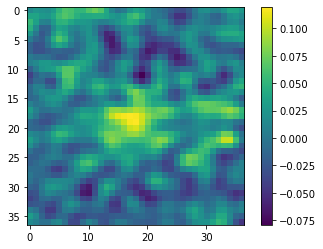

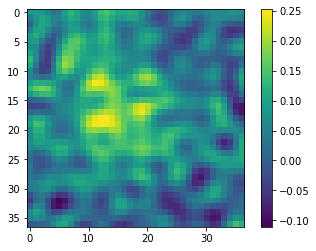

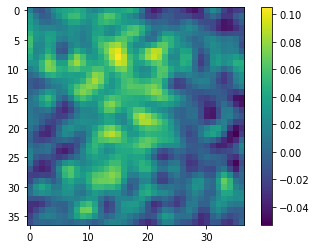

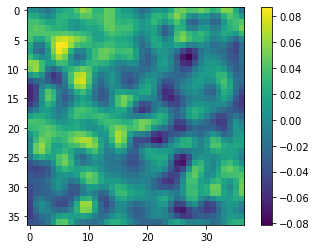

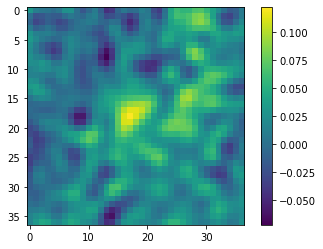

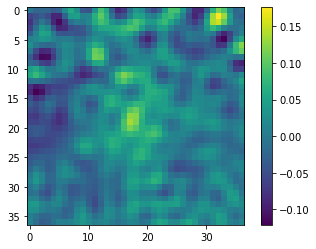

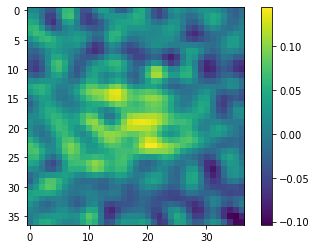

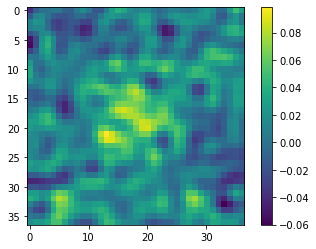

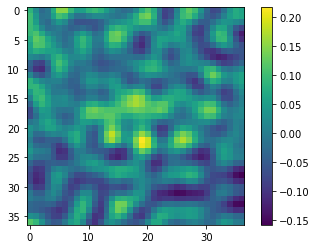

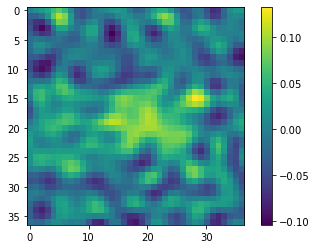

In [35]:
for i in range(10):
    plt.imshow(stamps[i,...,0])
    plt.colorbar()
    plt.show()
    plt.close()

In [45]:
data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=360, width_shift_range=4,
    height_shift_range=4,zoom_range=0.3)


history = model.fit(data_augmentation.flow(train_stamps, train_labels), epochs=int(50), 
                    validation_data=val_dataset)

Epoch 1/50
76/76 [==============================] - 2s 14ms/step - loss: 2.3533 - val_loss: 2.0953
Epoch 2/50
76/76 [==============================] - 1s 14ms/step - loss: 2.3910 - val_loss: 2.0895
Epoch 3/50
76/76 [==============================] - 1s 14ms/step - loss: 2.3191 - val_loss: 2.2337
Epoch 4/50
76/76 [==============================] - 1s 14ms/step - loss: 2.3270 - val_loss: 1.7170
Epoch 5/50
76/76 [==============================] - 1s 14ms/step - loss: 2.3595 - val_loss: 2.1278
Epoch 6/50
76/76 [==============================] - 1s 14ms/step - loss: 2.3451 - val_loss: 2.3051
Epoch 7/50
76/76 [==============================] - 1s 14ms/step - loss: 2.3439 - val_loss: 2.0507
Epoch 8/50
76/76 [==============================] - 1s 14ms/step - loss: 2.3169 - val_loss: 2.4958
Epoch 9/50
76/76 [==============================] - 1s 14ms/step - loss: 2.3496 - val_loss: 2.0693
Epoch 10/50
76/76 [==============================] - 1s 14ms/step - loss: 2.3344 - val_loss: 1.9988
Epoch 11/

In [46]:
errs_test = []
for thing in test_dataset:
    for i in range(thing[1].shape[0]):
        truth = thing[1][i]
        pred = model.predict(np.expand_dims(thing[0][i], axis = 0))
        errs_test.append((truth.numpy()-pred)/pred)
        
errs_val = []
for thing in val_dataset:
    for i in range(thing[1].shape[0]):
        truth = thing[1][i]
        pred = model.predict(np.expand_dims(thing[0][i], axis = 0))
        errs_val.append((truth.numpy()-pred)/pred)
        
print(np.mean(np.abs(errs_test)))
print(np.mean(np.abs(errs_val)))

0.29979357
0.2898087


0.00023466302192399463